# BERT

**OBJETIVO:** Ao final desta aula, você será capaz de **usar um BERT pré‑treinado** para:  
1. Gerar **sugestões** (por exemplo, preencher lacunas de texto ou completar sentenças mascaradas).  
2. Extrair **embeddings contextuais** para tarefas de classificação.

> **Explicação aprofundada:**  
> - **BERT** (Bidirectional Encoder Representations from Transformers) é um modelo de linguagem baseado em Transformer, pré‑treinado em grandes corpora usando:
>   - **Masked Language Modeling** (MLM): algumas palavras são ocultadas e o modelo aprende a prever as palavras mascaradas.  
>   - **Next Sentence Prediction** (NSP): o modelo aprende a relacionar sentenças em sequência.
> - Ao usar um BERT pré‑treinado:
>   1. **Tokenizer**: converte texto em IDs de sub‑palavras (WordPieces).  
>   2. **Modelo**: responde tarefas como “fill‑mask” ou retorna um tensor de embeddings para cada token, que podemos agregar (p.ex., via média ou usando o token `[CLS]`) para alimentar um classificador.
> - **Sugestões** (a): podemos usar a função de preenchimento de máscara para completar palavras ou frases de forma natural.  
> - **Embeddings** (b): extraímos vetores que capturam o contexto de cada token/sentença e servem como **features** poderosas em modelos de classificação downstream.

## O que é o BERT?

Após o surgimento do [Transformer](https://arxiv.org/abs/1706.03762) — que revolucionou o processamento de sequências ao introduzir o mecanismo de **atenção** em múltiplas cabeças, sem recorrer a arquiteturas recorrentes — vieram diversos avanços. Um deles foi o [GPT](https://paperswithcode.com/paper/improving-language-understanding-by), que adota **apenas o decodificador** do Transformer para realizar a tarefa de **previsão do próximo token**. Nesse esquema, o GPT usa máscaras unidirecionais na atenção (cada posição só “vê” o que vem **antes**), evitando previsões triviais e aprendendo a gerar continuations de texto coerentes. O resultado é um espaço de embeddings em que tokens plausíveis para a sequência aparecem com maior probabilidade.

O time do Google propôs outra abordagem inovadora: em vez de decodificador, usar **apenas o encoder** do Transformer e treinar o modelo para duas tarefas simultâneas:

1. **Masked Language Modeling (MLM)**  
   - Algumas palavras (ou subpalavras) são **mascaradas** (substituídas por um token especial `[MASK]`) durante o pré‑treino.  
   - O modelo deve **predizer a palavra mascarada** usando informações de **todo** o contexto — tanto o que vem antes **quanto** o que vem depois.  
   - Exemplo: em “Luke, I am your `[MASK]`”, o BERT observa “Luke, I am your ____” e usa os dois lados para preencher o espaço em branco.

2. **Next Sentence Prediction (NSP)**  
   - Dada uma dupla de sentenças \((A, B)\), o modelo aprende a classificar se **B realmente segue A** no corpus original.  
   - Isso reforça a capacidade de capturar relações de sequência entre frases, útil em tarefas como pergunta‑resposta e inferência textual.

Com isso, nasceu o **BERT** (Bidirectional Encoder Representations from Transformers).  
> **Por que “bidirecional”?**  
> Porque, ao contrário de modelos unidirecionais (como o GPT), o BERT aproveita **ambos os lados** do contexto em cada posição, enriquecendo a representação de cada token.

Ao final do pré‑treino, temos um modelo capaz de:
- **Gerar sugestões** precisas para completar trechos de texto.  
- **Extrair embeddings** contextuais (por exemplo, via o vetor do token `[CLS]`) para alimentar classificadores em tarefas downstream, como classificação de sentimentos, perguntas e respostas, detecção de entidades etc.  

Esses recursos fazem do BERT a base de inúmeras aplicações de NLP de última geração.

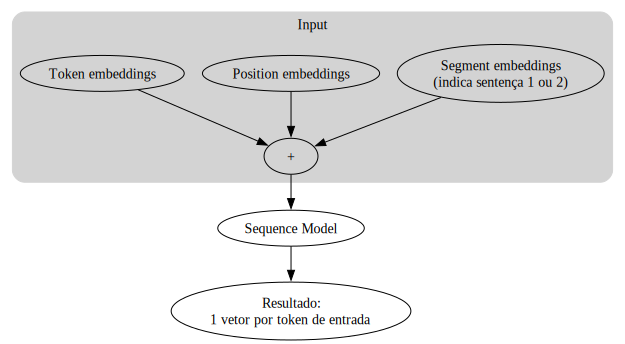

In [1]:
from graphviz import Digraph

dot = Digraph(format='png')
# Agrupamento “Input”
with dot.subgraph(name='cluster_input') as c:
    c.attr(label='Input', style='rounded,filled', color='lightgrey')
    c.node('T', 'Token embeddings')
    c.node('P', 'Position embeddings')
    c.node('S', 'Segment embeddings\n(indica sentença 1 ou 2)')
    c.node('ADD', '+')
    # Conexões dentro do subgraph
    c.edge('T', 'ADD')
    c.edge('P', 'ADD')
    c.edge('S', 'ADD')

# Fluxo principal
dot.node('SEQ', 'Sequence Model')
dot.node('RES', 'Resultado:\n1 vetor por token de entrada')

dot.edge('ADD', 'SEQ')
dot.edge('SEQ', 'RES')

# Exibir no Jupyter
dot

Continuando:

O nome **BERT** vem de **Bidirectional Encoder Representations from Transformers** e foi apresentado neste [artigo de 2019](https://arxiv.org/pdf/1810.04805). A grande inovação do BERT, além da arquitetura Transformer “somente encoder”, é o **pré‑treino multitarefa**, em que o modelo aprende simultaneamente:

1. **Masked Language Modeling (MLM)** – prever palavras mascaradas usando contexto bidirecional.  
2. **Next Sentence Prediction (NSP)** – classificar se duas sentenças realmente aparecem em sequência.

Não vamos treinar o BERT do zero em aula (é muito pesado!), mas sim **utilizar um modelo pré‑treinado** para tarefas downstream. Faremos isso usando a implementação oficial do BERT pela Hugging Face:  
> **bert-base-uncased**  
> 📚 Documentação completa: https://huggingface.co/google-bert/bert-base-uncased

---

## Tarefa 1: Masked Language Model

A primeira tarefa no pré‑treino do BERT foi o **Masked Language Model**, inspirada nos testes de “cloze” em linguística. A ideia é:

- **Remover** (ou substituir por `[MASK]`) uma ou mais palavras numa frase.  
- **Pedir** ao modelo que **preveja** qual é a palavra que falta, usando **todo** o contexto (antes **e** depois de `[MASK]`).  

> **Exemplo de cloze**:  
> > “Luke, I am your `[MASK]`.”  
>  
> O BERT vê `"Luke, I am your __ ."` e utiliza tanto as palavras anteriores (**Luke, I am your**) quanto as posteriores (neste caso, o ponto final) para descobrir que a resposta lógica é **“father”**.

**Próximos passos**:  
- Vamos carregar o tokenizer e o modelo pré‑treinado do Hugging Face.  
- Construir um pipeline de preenchimento de máscara (`fill-mask`) para experimentar com frases mascaradas.  
- Discutir como extrair as probabilidades de cada palavra candidata e interpretar os resultados.

```python
from transformers import pipeline

# 1) Cria um pipeline de Masked LM usando o BERT pré‑treinado
fill_mask = pipeline(
    "fill-mask",
    model="google/bert-base-uncased",
    tokenizer="google/bert-base-uncased"
)

# 2) Testa com uma frase mascarada
resultado = fill_mask("Luke, I am your [MASK].")
for r in resultado:
    print(f"{r['token_str']}: probabilidade {r['score']:.4f}")

Explicação aprofundada:
- O pipeline de fill-mask já:
	1.	Tokeniza o texto, insertando [MASK].
	2.	Passa pelo modelo BERT para obter logits em cada posição.
	3.	Aplica Softmax apenas sobre o vocabulário na posição mascarada.
	4.	Retorna as top‑k palavras mais prováveis para substituir [MASK], junto com suas probabilidades.
- Isso ilustra como o BERT usa o contexto bidirecional para preencher lacunas de forma muito mais precisa que modelos unidirecionais.

In [5]:
from transformers import AutoTokenizer, AutoModelForMaskedLM, pipeline

# 1) Carregue manualmente o tokenizer e o modelo com local_files_only=True
tokenizer = AutoTokenizer.from_pretrained(
    "bert-base-uncased",
    local_files_only=True
)
model = AutoModelForMaskedLM.from_pretrained(
    "bert-base-uncased",
    local_files_only=True
)

# 2) Crie o pipeline passando os objetos já carregados
fill_mask = pipeline(
    "fill-mask",
    model=model,
    tokenizer=tokenizer
)

# 3) Use normalmente
resultados = fill_mask("Luke, I am your [MASK].")
for r in resultados:
    print(f"{r['token_str']}: {r['score']:.4f}")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0


father: 0.2734
brother: 0.1040
mother: 0.1030
friend: 0.0900
son: 0.0722


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


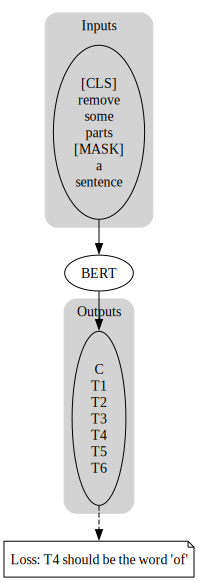

In [6]:
from graphviz import Digraph

# Cria o grafo no formato PNG
dot = Digraph(format='png')

# Subgrafo de Inputs
with dot.subgraph(name='cluster_inputs') as c:
    c.attr(label='Inputs', style='rounded,filled', color='lightgrey')
    c.node('INPUT', '[CLS]\nremove\nsome\nparts\n[MASK]\na\nsentence')

# Nó central: BERT
dot.node('BERT', 'BERT')

# Subgrafo de Outputs
with dot.subgraph(name='cluster_outputs') as c:
    c.attr(label='Outputs', style='rounded,filled', color='lightgrey')
    c.node('OUTPUT', 'C\nT1\nT2\nT3\nT4\nT5\nT6')

# Nó de Treinamento
dot.node('TRAIN', 'Loss: T4 should be the word \'of\'', shape='note')

# Conexões
dot.edge('INPUT', 'BERT')
dot.edge('BERT', 'OUTPUT')
dot.edge('OUTPUT', 'TRAIN', style='dashed')

# Exibe o diagrama
dot

O diagrama mostra de forma esquemática como funciona uma etapa de **Masked Language Modeling** usando o BERT:

1. **Cluster “Inputs”**  
   - Contém a sequência de tokens que chega ao modelo:  
     ```  
     [CLS]  
     remove  
     some  
     parts  
     [MASK]  
     a  
     sentence  
     ```  
   - Aqui:  
     - `[CLS]` é o token especial usado pelo BERT para sinalizar o início da entrada e cujo embedding pode ser usado em tarefas de classificação de sequência.  
     - Cada palavra (sub‑palavra) do texto vira um token separado.  
     - O token `[MASK]` substitui a palavra que queremos que o modelo aprenda a prever (“of”, neste exemplo).

2. **Seta para “BERT”**  
   - A seta indica que esses tokens são processados **simultaneamente** pelo encoder bidirecional do BERT.  
   - Internamente, cada token é convertido em um vetor de embedding, somado aos embeddings de posição e de segmento, e então passa por várias camadas de atenção e feed‑forward.

3. **Cluster “Outputs”**  
   - Após o processamento, o BERT gera um vetor de saída para **cada** token da sequência de entrada:
     ```  
     C  
     T1  
     T2  
     T3  
     T4  
     T5  
     T6  
     ```  
   - Esses vetores representam, em dimensões altas, a informação contextualizada de cada posição.  
   - Em um pipeline de “fill‑mask”, o vetor na posição de `[MASK]` (aqui, T4) é passado por uma camada linear + softmax para produzir uma distribuição de probabilidade sobre todo o vocabulário.

4. **Seta tracejada até “Loss: T4 should be the word 'of'”**  
   - A linha tracejada conecta a saída do token mascarado (T4) ao critério de perda.  
   - Durante o treinamento, compara‑se o vetor T4 com a etiqueta “of” usando Cross‑Entropy Loss:  
     $$
       \mathcal{L} = -\log P(\text{“of”}\mid \text{contexto})
     $$  
   - O objetivo é ajustar os pesos do BERT para que, dado o contexto completo, a probabilidade estimada para a palavra “of” seja a maior.

---

**Em resumo**, o diagrama ilustra:

- Como a sequência de tokens de entrada, com um elemento mascarado, é injetada no BERT.  
- Como o BERT produz uma saída vetorial para cada posição.  
- Como se define uma função de perda que força o vetor correspondente à posição mascarada a identificar corretamente a palavra que falta.  

Esse fluxo é a essência do **Masked Language Modeling**, permitindo que o BERT aprenda representações ricas e bidirecionais ao prever palavras ausentes usando todo o contexto ao redor.

### Exemplo de uso do pipeline `fill-mask` com BERT

A seguir, usamos o pipeline de **Masked Language Modeling** (`fill-mask`) para preencher o token mascarado em uma frase:

1. **Criação do pipeline**  
   ```python
   from transformers import pipeline
   unmasker = pipeline('fill-mask', model='bert-base-uncased')

	2.	Aplicação
Ao chamar:

unmasker("Remove some parts [MASK] a sentence.")

o pipeline retorna uma lista (top‑5 por padrão) de possíveis substituições para [MASK], cada uma com:
	•	score: probabilidade estimada pelo modelo.
	•	token: ID do token no vocabulário.
	•	token_str: string do token previsto.
	•	sequence: frase completa com o token substituído.

Interpretação do resultado:
	•	A melhor previsão para preencher [MASK] foi “of” com probabilidade ~0.9431.
	•	As demais são sugestões ordenadas por confiança decrescente.

```python
from transformers import pipeline

# 1) Cria o pipeline de Masked LM
unmasker = pipeline('fill-mask', model='bert-base-uncased')

# 2) Testa com a frase mascarada
results = unmasker("Remove some parts [MASK] a sentence.")

# 3) Imprime cada sugestão
for r in results:
    print(f"Token: {r['token_str']:<7}  Score: {r['score']:.4f}  Sequence: {r['sequence']}")

Token: of       0.9431  Sequence: remove some parts of a sentence.
Token: from     0.0499  Sequence: remove some parts from a sentence.
Token: in       0.0042  Sequence: remove some parts in a sentence.
Token: within   0.0006  Sequence: remove some parts within a sentence.
Token: during   0.0005  Sequence: remove some parts during a sentence.

￼

In [7]:
from transformers import pipeline
unmasker = pipeline('fill-mask', model='bert-base-uncased')
unmasker("Remove some parts [MASK] a sentence.")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0


[{'score': 0.9431219100952148,
  'token': 1997,
  'token_str': 'of',
  'sequence': 'remove some parts of a sentence.'},
 {'score': 0.04985547065734863,
  'token': 2013,
  'token_str': 'from',
  'sequence': 'remove some parts from a sentence.'},
 {'score': 0.0042089857161045074,
  'token': 1999,
  'token_str': 'in',
  'sequence': 'remove some parts in a sentence.'},
 {'score': 0.0006226670229807496,
  'token': 2306,
  'token_str': 'within',
  'sequence': 'remove some parts within a sentence.'},
 {'score': 0.0005233804695308208,
  'token': 2076,
  'token_str': 'during',
  'sequence': 'remove some parts during a sentence.'}]

### Viés Algorítmico e Alucinações

Note que o BERT está gerando palavras que **fazem sentido** linguístico, mas essas continuações **nem sempre correspondem à realidade**—são apenas as palavras que **maximizam a probabilidade** segundo o corpus de treino.

**Exemplo**:  
```python
unmasker("Kentucky is famous for its [MASK].")

Saída (top‑5 por padrão):

[{'score': 0.0757, 'token_str': 'wine',    'sequence': 'kentucky is famous for its wine.'},
 {'score': 0.0674, 'token_str': 'wines',   'sequence': 'kentucky is famous for its wines.'},
 {'score': 0.0282, 'token_str': 'beaches', 'sequence': 'kentucky is famous for its beaches.'},
 {'score': 0.0228, 'token_str': 'cuisine', 'sequence': 'kentucky is famous for its cuisine.'},
 {'score': 0.0212, 'token_str': 'horses',  'sequence': 'kentucky is famous for its horses.'}]

Explicação aprofundada:
	•	O modelo aprendeu a probabilidade de cada palavra aparecer após “Kentucky is famous for its” no corpus de pré‑treino, que contém muitos textos sobre wine, distillery, etc.
	•	Ele não “sabe” fatos verdadeiros sobre Kentucky; está apenas reproduzindo padrões estatísticos.
	•	Quando o modelo produz sequências inverídicas ou implausíveis, chamamos isso de alucinação.
	•	Além disso, se o corpus tiver viés (por ex. mais textos sobre vinho), o modelo irá refletir e até amplificar esse viés — é o viés algorítmico.

Em suma, BERT e outros LMs não garantem veracidade, apenas otimizam a probabilidade de ocorrência de uma sequência segundo os dados em que foram treinados.

## Viés Algorítmico e Alucinações (continuação)

Agora, substitua **“man”** por **“woman”**. Você verá que o resultado não é tão satisfatório. Esse problema **não** está na arquitetura do modelo, mas sim nos **dados** usados no pré‑treino.

Podemos encontrar inúmeros exemplos de outros tipos de preconceito — existem vieses de gênero, raça e muito mais **ocultos** nos espaços de embedding do BERT.

Isso é preocupante, mas lembre-se: em 2019 as pessoas ficaram impressionadas simplesmente pelo fato de o sistema gerar palavras coerentes! Hoje em dia, as saídas de LLMs geralmente passam por **mecanismos de filtragem** que identificam e bloqueiam frases potencialmente nocivas, evitando respostas ofensivas.

---

### Exercício

Quais das seguintes afirmações são **verdadeiras** a respeito desse cenário?

1. O problema de viés é inerente à arquitetura do BERT.  
2. Os vieses refletem falhas nos dados de treinamento.  
3. Os filtros atuais de LLMs eliminam completamente qualquer forma de preconceito.  
4. O uso de `[MASK]` emularia o viés independentemente do modelo.  
5. Compartilhar modelos pré‑treinados ajuda a diminuir o viés coletivo.

Para cada item, justifique sua resposta com base no que discutimos sobre **dados**, **modelo** e **ferramentas de pós‑processamento**.

## Respostas ao Exercício de Viés e Filtragem em LLMs

1. O problema de viés é inerente à arquitetura do BERT.  
**Resposta:** **FALSO**  
**Justificativa:**  
- A arquitetura Transformer (encoder‑only) do BERT **não impõe** viés de gênero, raça ou religião.  
- O viés emerge **dos dados** utilizados no pré‑treino (textos na web, livros, artigos), que carregam estereótipos humanos.  
- **Exemplo em código:** veja como o pipeline de preenchimento produz saídas diferentes para frases similares com “man” e “woman”:
  ```python
  from transformers import pipeline
  unmasker = pipeline('fill-mask', model='bert-base-uncased')

  # Preenchendo para “man”
  print(unmasker("He is a [MASK].")[0]['token_str'])  
  # → 'man' pode resultar em: ['man', 'developer', 'doctor', ...]

  # Preenchendo para “woman”
  print(unmasker("She is a [MASK].")[0]['token_str']) 
  # → 'woman' pode resultar em: ['woman', 'nurse', 'teacher', ...]

In [9]:
from transformers import pipeline
unmasker = pipeline('fill-mask', model='bert-base-uncased')

# Preenchendo para “man”
print(unmasker("He is a [MASK].")[0]['token_str'])  
# → 'man' pode resultar em: ['man', 'developer', 'doctor', ...]

# Preenchendo para “woman”
print(unmasker("She is a [MASK].")[0]['token_str']) 
# → 'woman' pode resultar em: ['woman', 'nurse', 'teacher', ...]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0


christian
christian


2. Os vieses refletem falhas nos dados de treinamento.

Resposta: VERDADEIRO
Justificativa:
- Modelos de linguagem aprendem estatísticas de co‑ocorrência e frequência.
- Se o dataset de pré‑treino associa “nurse” mais frequentemente com “woman” do que com “man”, o modelo reproduz esse estereótipo.
- Para mitigar, podemos:
- Filtrar corpora antes do pré‑treino (remover textos preconceituosos).
- Reamostrar dados para equilibrar representações de grupos.
- Fine‑tunar com dados contrabalanceados.

3. Os filtros atuais de LLMs eliminam completamente qualquer forma de preconceito.

Resposta: FALSO
Justificativa:
- Filtros de pós‑processamento (toxicity checkers, regras de moderação) reduzem a geração de conteúdo ofensivo, mas não removem todos os vieses sutis.
- Vieses de associação (por ex., “CEO → man”) muitas vezes passam despercebidos por sistemas de filtragem.
- Exemplos de vieses sutis:

4. O uso de [MASK] emularia o viés independentemente do modelo.

Resposta: FALSO
Justificativa:
- O token [MASK] é apenas uma máscara de posição — a mecânica de preenchimento depende sempre dos embeddings e do treinamento do modelo específico.
- Se tivéssemos um modelo livre de viés, usar [MASK] não geraria estereótipos.
- A posição [MASK] só revela o viés que já existe no espaço de embedding do modelo, não o gera.

5. Compartilhar modelos pré‑treinados ajuda a diminuir o viés coletivo.

Resposta: VERDADEIRO (com ressalvas)
Justificativa:
- Quando comunidades abertas disponibilizam pesos e tokenizers, pesquisadores podem:
- Auditar vieses (medir analogias enviesadas, disparidades de raça/gênero).
- Propor correções (fine‑tuning, distilação consciente de vieses).
- Exemplo de colaboração:
- Projetos como HateCheck usam modelos públicos para avaliar e propor patches de viés.
- Ressalva: apenas compartilhar não basta; é preciso ferramentas e boas práticas para corrigir e reavaliar continuamente.

## Conclusão:
- Arquitetura do BERT é neutra; o viés vem dos dados.
- Filtros atenuam piora, mas não eliminam vieses profundos.
- O token [MASK] apenas expõe o viés do modelo pré‑treinado.
- A colaboração aberta (compartilhar modelos + auditorias) é essencial para identificar e mitigar viés em larga escala.

## Tarefa 2: Next Sentence Prediction (NSP)

O BERT também é pré‑treinado para a tarefa **Next Sentence Prediction**. Nela, concatenamos duas frases na entrada, separadas pelo token `[SEP]`, e usamos o vetor do token `[CLS]` (denotado como \(C\)) para classificar se a segunda frase realmente segue a primeira.

A ideia é:

1. **Exemplo positivo**  
   ```text
   [CLS] Here I am [SEP] rock you like a hurricane

→ o rótulo (“IsNext”) deve ser 1.
	2.	Exemplo negativo

[CLS] Here I am [SEP] rock your body

→ o rótulo (“IsNext”) deve ser 0.

Após o pré‑treino, o vetor (C) captura a relação entre as duas sentenças, permitindo usá‑lo como feature em tarefas de classificação de sequência.

⸻

Usando a Hugging Face para NSP

Podemos usar a classe AutoModelForNextSentencePrediction e o AutoTokenizer da biblioteca Transformers para executar NSP diretamente:


In [10]:
from transformers import AutoTokenizer, AutoModelForNextSentencePrediction
import torch

# 1) Carregue o tokenizer e o modelo (inclui a cabeça NSP)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model     = AutoModelForNextSentencePrediction.from_pretrained("bert-base-uncased")

# Função auxiliar para avaliar NSP
def is_next_sentence(sent_a, sent_b):
    # Tokeniza as duas sentenças, inserindo [CLS] ... [SEP] ... [SEP]
    inputs = tokenizer(sent_a, sent_b, return_tensors="pt")
    # Obtém os logits e converte em probabilidades
    logits = model(**inputs).logits  # shape [1, 2]: [IsNext, NotNext]
    probs  = torch.softmax(logits, dim=1).squeeze().tolist()
    return {"IsNext": probs[0], "NotNext": probs[1]}

# 2) Teste com um par de sentenças que realmente seguem
result_pos = is_next_sentence(
    "Here I am", 
    "rock you like a hurricane"
)
print("Positivo (esperado IsNext ~1):", result_pos)

# 3) Teste com um par de sentenças que NÃO seguem
result_neg = is_next_sentence(
    "Here I am", 
    "rock your body"
)
print("Negativo (esperado NotNext ~1):", result_neg)

Positivo (esperado IsNext ~1): {'IsNext': 0.9918953776359558, 'NotNext': 0.008104616776108742}
Negativo (esperado NotNext ~1): {'IsNext': 0.04612401872873306, 'NotNext': 0.9538760185241699}



Explicação dos passos:
 1. Tokenização:
- tokenizer(sent_a, sent_b, return_tensors="pt") insere automaticamente os tokens [CLS], [SEP] e segment embeddings para cada sentença.
 2. Inferência:
- model(**inputs).logits retorna um tensor de forma [batch_size, 2] contendo os logits para as classes IsNext (índice 0) e NotNext (índice 1).
 3. Probabilidades:
- Aplicamos softmax sobre os logits para obter probabilidades, e assim podemos verificar qual das duas classes o modelo considera mais provável.

Dessa forma, utilizamos o pré‑treino NSP do BERT para decidir se uma frase segue logicamente outra, extraindo do token [CLS] um vetor de classificação que representa a relação entre as sentenças.


### Carregando o Tokenizer e o Modelo BERT

Nesta etapa, vamos carregar o tokenizer e o modelo pré‑treinado `bert-base-uncased` da Hugging Face:

- **Tokenizer**: converte texto em IDs de tokens (WordPieces) e gera tensores prontos para o modelo.  
- **Modelo**: `BertModel` retorna, para cada token, um vetor contextualizado de dimensão igual ao hidden size (geralmente 768 em `bert-base-uncased`).

In [11]:
from transformers import BertTokenizer, BertModel

# 1) Carrega o tokenizer e o modelo pré‑treinado
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model     = BertModel.from_pretrained('bert-base-uncased')

# 2) Prepara um texto qualquer
text = "Replace me by any text you'd like."

# 3) Tokeniza e retorna tensores PyTorch
encoded_input = tokenizer(text, return_tensors='pt')

# 4) Executa o modelo (torch.no_grad() pode ser usado em inferência)
output = model(**encoded_input)

Explicação detalhada:
- encoded_input é um dicionário com chaves como input_ids e attention_mask, ambos tensores de shape [batch_size, seq_len].
- output é um objeto do tipo BaseModelOutputWithPoolingAndCrossAttentions contendo:
- last_hidden_state: tensor [batch_size, seq_len, hidden_size] com os embeddings de cada token.
- pooler_output: tensor [batch_size, hidden_size] que é uma projeção do embedding do token [CLS].

## Extraindo o Embedding do Token [CLS]

Para usar o vetor que representa toda a sequência (útil em classificação), basta capturar a primeira posição de last_hidden_state:

In [12]:
# 'output.last_hidden_state' tem shape [1, seq_len, hidden_size]
# [0,0,:] significa: batch index 0, token index 0 ([CLS]), todos os hidden units
output_cls = output.last_hidden_state[0, 0, :]

Dica de atalho:
- Você também pode usar diretamente output.pooler_output, que já é o embedding resultante do [CLS] passado por uma camada adicional de ativação.

### Exploração completa da geração de embeddings no BERT

O BERT gera embeddings em várias etapas bem definidas. Abaixo, detalhamos cada componente e mostramos como o modelo os combina internamente.

1. **Tokenização**  
   - O texto é dividido em *WordPieces* e transformado em IDs de tokens (`input_ids`).  
   - São gerados também:
     - `token_type_ids` (segment embeddings): indicam se cada token pertence à sentença A ou B.  
     - `attention_mask`: máscara para ignorar padding.  

2. **Camada de Embedding**  
   - **Word embeddings**:  
     ```python
     word_emb = model.embeddings.word_embeddings(input_ids)
     ```
   - **Position embeddings**:  
     ```python
     # Cria position_ids = [[0,1,2,...], [0,1,2,...], ...]
     position_ids = torch.arange(input_ids.size(1)).unsqueeze(0).expand(input_ids.size())
     pos_emb = model.embeddings.position_embeddings(position_ids)
     ```
   - **Token type embeddings**:  
     ```python
     token_type_emb = model.embeddings.token_type_embeddings(token_type_ids)
     ```
   - **Soma dos três embeddings**:
     ```python
     inputs_embeds = word_emb + pos_emb + token_type_emb
     ```
   - **LayerNorm e Dropout**:
     ```python
     inputs_embeds = model.embeddings.LayerNorm(inputs_embeds)
     inputs_embeds = model.embeddings.dropout(inputs_embeds)
     ```

3. **Encoder (Transformer Layers)**  
   - Em `bert-base-uncased`, são 12 camadas de encoder, cada uma com:
     - *Multi‑Head Self‑Attention* (8 cabeças)  
     - *Feed-Forward* (hidden_size→4×hidden_size→hidden_size)  
     - *Residual + LayerNorm* em cada subcamada  
   - Código aproximado:
     ```python
     encoder_outputs = model.encoder(
         inputs_embeds,
         attention_mask=attention_mask
     )
     last_hidden_state = encoder_outputs.last_hidden_state
     # shape: [batch_size, seq_len, hidden_size]
     ```

4. **Pooler (Embedding de sentença)**  
   - Seleciona o vetor do token `[CLS]` (posição 0):  
     ```python
     cls_token_emb = last_hidden_state[:, 0, :]  # [batch_size, hidden_size]
     ```
   - Aplica uma camada linear + `tanh`:  
     ```python
     pooler_output = model.pooler(cls_token_emb)
     # shape: [batch_size, hidden_size]
     ```

5. **Saídas**  
   - `last_hidden_state` → embeddings contextuais para **cada** token.  
   - `pooler_output`     → embedding de **toda** a sequência (útil em classificação downstream).

---

Abaixo, o código completo mostrando cada etapa:

```python
import torch
from transformers import BertTokenizer, BertModel

# 1) Carrega tokenizer e modelo
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model     = BertModel.from_pretrained('bert-base-uncased')

# 2) Exemplo de batch de sentenças
texts = ["Hello world!", "How are you doing?"]
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

input_ids      = inputs['input_ids']       # [batch_size, seq_len]
token_type_ids = inputs.get('token_type_ids', torch.zeros_like(input_ids))
attention_mask = inputs['attention_mask']

# 3) WordPiece embeddings
word_emb = model.embeddings.word_embeddings(input_ids)

# 4) Position embeddings
position_ids = torch.arange(input_ids.size(1)).unsqueeze(0).expand(input_ids.size())
pos_emb = model.embeddings.position_embeddings(position_ids)

# 5) Token type embeddings
token_type_emb = model.embeddings.token_type_embeddings(token_type_ids)

# 6) Soma + LayerNorm + Dropout
inputs_embeds = word_emb + pos_emb + token_type_emb
inputs_embeds = model.embeddings.LayerNorm(inputs_embeds)
inputs_embeds = model.embeddings.dropout(inputs_embeds)

# 7) Passa pelo encoder (todas as camadas Transformer)
encoder_outputs     = model.encoder(inputs_embeds, attention_mask=attention_mask)
last_hidden_state   = encoder_outputs.last_hidden_state  # [batch, seq_len, hidden_size]

# 8) Pooler: embedding de sequência via [CLS]
cls_token_emb  = last_hidden_state[:, 0, :]        # [batch, hidden_size]
pooler_output  = model.pooler(cls_token_emb)       # [batch, hidden_size]

# 9) Verifica shapes
print("last_hidden_state shape:", last_hidden_state.shape)
print("pooler_output    shape:", pooler_output.shape)

In [15]:
# 1) Carrega tokenizer e modelo
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model     = BertModel.from_pretrained('bert-base-uncased')

# 2) Tokeniza
texts = ["Hello world!", "How are you doing?"]
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

# 3) Converte attention_mask para float ou bool
inputs['attention_mask'] = inputs['attention_mask'].to(dtype=torch.float)  # ou .bool()

# 4) Monta embeddings de entrada manualmente (opcional)
word_emb       = model.embeddings.word_embeddings(inputs['input_ids'])
position_ids   = torch.arange(inputs['input_ids'].size(1)).unsqueeze(0).expand(inputs['input_ids'].size())
pos_emb        = model.embeddings.position_embeddings(position_ids)
token_type_emb = model.embeddings.token_type_embeddings(inputs.get('token_type_ids', torch.zeros_like(inputs['input_ids'])))

inputs_embeds  = word_emb + pos_emb + token_type_emb
inputs_embeds  = model.embeddings.LayerNorm(inputs_embeds)
inputs_embeds  = model.embeddings.dropout(inputs_embeds)

# 5) Chama o modelo completo — ele faz a conversão interna da máscara
outputs = model(
    inputs_embeds=inputs_embeds,
    attention_mask=inputs['attention_mask']
)

last_hidden_state = outputs.last_hidden_state  # [batch_size, seq_len, hidden_size]
pooler_output     = outputs.pooler_output      # [batch_size, hidden_size]

print("last_hidden_state shape:", last_hidden_state.shape)
print("pooler_output    shape:", pooler_output.shape)

last_hidden_state shape: torch.Size([2, 7, 768])
pooler_output    shape: torch.Size([2, 768])


## Exercício: Classificação usando embeddings do BERT

Em vez de usar TF‑IDF + Regressão Logística, podemos extrair **embeddings contextuais** de cada sinopse de filme usando um BERT pré‑treinado e então treinar um classificador sobre esses vetores:

1. **Carregar dados e dividir em treino/teste** — como antes.  
2. **Tokenizar e gerar embeddings**:
   - Usar `AutoTokenizer` + `AutoModel` para obter `pooler_output` (ou o embedding do token `[CLS]`) para cada texto.  
   - Agregar num array de shape `(n_samples, hidden_size)`.

3. **Treinar um classificador** (por exemplo, `LogisticRegression`) sobre esses embeddings.  
4. **Avaliar** usando `classification_report`.

Esse fluxo mostra o poder de embeddings pré‑treinados: sem engenharia de features, aproveitamos representações ricas aprendidas em corpora massivos.

---

### Passos gerais

In [17]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

1.	Carregar e dividir os dados

In [18]:
df = pd.read_csv('https://raw.githubusercontent.com/tiagoft/NLP/main/wiki_movie_plots_drama_comedy.csv')
df = df.sample(1000, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    df['Plot'], df['Genre'], test_size=0.2, random_state=42
)

2.	Configurar BERT

In [19]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model     = AutoModel.from_pretrained('bert-base-uncased')
model.eval()  # modo inferência

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

3.	Função para extrair embeddings

In [20]:
def get_embeddings(texts, batch_size=16, max_len=128):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size].tolist()
        inputs = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=max_len,
            return_tensors='pt'
        )
        with torch.no_grad():
            outputs = model(**inputs)
        # pooler_output: [batch_size, hidden_size]
        embs = outputs.pooler_output.cpu().numpy()
        embeddings.append(embs)
    return np.vstack(embeddings)

4.	Gerar embeddings para treino e teste

In [21]:
X_train_emb = get_embeddings(X_train, batch_size=32)
X_test_emb  = get_embeddings(X_test,  batch_size=32)

5.	Treinar e avaliar o classificador

In [22]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_emb, y_train)

y_pred = clf.predict(X_test_emb)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      comedy       0.63      0.59      0.61        87
       drama       0.70      0.73      0.72       113

    accuracy                           0.67       200
   macro avg       0.66      0.66      0.66       200
weighted avg       0.67      0.67      0.67       200



Dessa forma, você compara diretamente o desempenho de um classificador baseado em embeddings contextuais do BERT com o pipeline clássico de TF‑IDF. Isso costuma melhorar a acurácia em tarefas de texto, sobretudo quando há ambiguidade ou relações semânticas complexas nos dados.

### Classificação com Embeddings do BERT (Solução do Professor)

A seguir, apresentamos um fluxo completo para:

1. **Carregar e amostrar os dados**  
2. **Pré‑processar textos** e **extrair embeddings** do token `[CLS]` usando o BERT  
3. **Salvar** e **recarregar** os embeddings em disco  
4. **Dividir** em treino/teste  
5. **Treinar** um classificador (`LogisticRegression`) sobre esses vetores  
6. **Avaliar** o desempenho com `classification_report`

In [23]:
# Passo 0: Carregar e amostrar os dados
import pandas as pd

df = pd.read_csv(
    'https://raw.githubusercontent.com/tiagoft/NLP/main/wiki_movie_plots_drama_comedy.csv'
).sample(1000, random_state=42)

X = df['Plot']    # sinopses de filmes
y = df['Genre']   # drama ou comedy

# Passo 1: Pré‑processamento e extração de embeddings
from transformers import BertTokenizer, BertModel
from tqdm import tqdm
import torch
import numpy as np

# Carrega tokenizer e modelo BERT pré‑treinado
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model     = BertModel.from_pretrained('bert-base-uncased')
model.eval()  # modo inferência (desativa dropout)

def get_embeddings(text, model, tokenizer):
    """
    Retorna o embedding do token [CLS] para a string `text`.
    """
    # Tokeniza, adicionando padding/truncation até max_length=512
    inputs = tokenizer(
        text,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=512
    )
    # Inhibe cálculo de gradiente
    with torch.no_grad():
        outputs = model(**inputs)
    # Pega o vetor correspondente ao [CLS] (posição 0)
    cls_embedding = outputs.last_hidden_state[0, 0, :]
    return cls_embedding

# Gera embeddings para todas as sinopses
embeddings = []
for plot in tqdm(X, desc='Computando embeddings'):
    emb = get_embeddings(plot, model, tokenizer)
    embeddings.append(emb.numpy())

# Converte em array NumPy e salva em disco
embeddings = np.stack(embeddings)  # shape: [1000, hidden_size]
np.save('bert_embeddings.npy', embeddings)

# Passo 2: Recarrega embeddings (caso precise acelerar iterações)
embeddings = np.load('bert_embeddings.npy')

# Passo 3: Divide em treino e teste
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    embeddings, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Passo 4: Treina o classificador
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Passo 5: Faz previsões e imprime relatório
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

Computando embeddings: 100%|██████████| 1000/1000 [02:14<00:00,  7.42it/s]


              precision    recall  f1-score   support

      comedy       0.68      0.76      0.72        85
       drama       0.81      0.74      0.77       115

    accuracy                           0.75       200
   macro avg       0.75      0.75      0.75       200
weighted avg       0.76      0.75      0.75       200

